# Assignment

We saw a few examples of machine learning algorithms, so at this point it seems like once you get the data ready, machine learning is just "plug and play", but not so fast! 

In this assignment, we learn about **regularization**! Regularization is a means by which we can control how much a machine learning algorithm learns. The controlling is done using a parameter that the algorithm, called the **shrinkage parameter**, which is just an argument of the algorithm. The shrinkage parameter is an example of a **hyper-parameter**. A hyper-parameter is like a knob: by specifying a different value for the hyper-parameter, we control how the training happens, a process called **hyper-parameter tuning**. We talk about this is more detail in the next lesson.

We will look at two examples of regularizaiton: LASSO and Ridge regression. Both LASSO and Ridge regression are implementations of linear regression where we try to minimize prediction error plus some penalty that depends on the model's parameters (or coefficients) and the shrinkage constant (`alpha` in the code below). LASSO penalizes the model's parameters using the sum of the **absolute values** of the parameters (this is also called **L1-regularization**), while Ridge does so based on the sum of the **squared values** of the parameters (this is also called **L2-regularization**). For reasons we cannot elaborate on here, **LASSO has the by-product that it also does feature selection**, whereas Ridge doesn't. So not all regularization results in feature selection.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Root Mean Squared Error (RMSE)
Before we dive into regularization we need to have a metric that tells us if our regression is good or bad.  For regressions we measure success differently than with classifications.  Instead of accuracy, the primary measure is **Root Mean Squared Error** (**RMSE**).  A **RMSE** of zero occurs when the predictions are perfect. **RMSE** increases as the predictions get worse. Let's disect the term **Root Mean Squared Error** by understanding each word from right to left.

### Error
The **E** in **RMSE** stands for **E**rror ($e_i$).  The error ($e_i$) is the difference between the known test target value ($y_i$) of sample $i$ and the predicted target value ($\hat{y}_i$) based on the test inputs of sample $i$.
$$e_i = y_i - \hat{y}_i$$
where
- $e_i$ is the error of the $i$th sample
- $y_i$ is the test target value of the $i$th sample
- $\hat{y}_i$ is the predicted target value from the inputs of the $i$th sample

### Squared
The **S** in **RMSE** stands for squared.  The errors ($e_i$) are squared: $(e_i)^2$.  

### Mean
The **M** in **RMSE** stands for mean.  We get the mean squared error (**MSE**) by taking the mean of all the squared errors in the sample:
$$\text{MSE} = \frac{1}{n}\sum_{i}(e_i)^2$$
where
- $\text{MSE}$ is the mean squared error
- $n$ is the number of samples

### Root
The **R** in **RMSE** stands for root.  We get the root mean squared error (**RMSE**) by taking the square root mean of **MSE**
$$\text{RMSE} = \sqrt{\text{MSE}}$$

Both **MSE** and **RMSE** are used to measure the prediction error.  **RMSE** is often preferred because it is in the units of the target variable ($y$), whereas **MSE** is in units of the target variable squared ($y^2$).

0. Compute error metrics.  
<br/>
To make sure we understand RMSE, lets do one small exercise.

We have the following data:
- The actual test target values are: `20, 15, 12, 17, 15, 14, 19, 17`
- The predicted target values predicted from test inputs are: `19, 12, 12, 19, 17, 17, 17, 18`

Determine and show
1. the 8 errors
2. the 8 squared errors derived from the errors
3. the MSE derived from the 8 squared errors
4. the RMSE derived from the MSE
5. the RMSE derived from the actual test target values and the predicted target values using sklearn.metrics.mean_squared_error with squared=False
<br/><span style="color:red" float:right>[1 point]</span>

##### 1.

In [2]:
# create two variables y and y_hat
values = [20, 15, 12, 17, 15, 14, 19, 17]
predictions = [19, 12, 12, 19, 17, 17, 17, 18]

# zip lists, just for practice
paired_list = list(zip(values, predictions))

# get differences
errors = []
for c, v in paired_list:
    errors.append(c-v)
    
# print errors
print("8 Errors: ")
errors = np.array(errors)
errors

8 Errors: 


array([ 1,  3,  0, -2, -2, -3,  2, -1])

**Thought this was a handy way of creating the array with the actual - predicted values. I changed them into an array so that I could do array math on them, rather than keeping them in a list and having to create for loops. I also wanted to practice the zipping technique that was shown in class.**

##### 2.

In [3]:
# square the errors
squared_errors = errors**2

print("8 Squared errors")
squared_errors

8 Squared errors


array([1, 9, 0, 4, 4, 9, 4, 1])

**Easily squared each number since the errors were in an array**

##### 3.

In [4]:
# Derive Mean Squared Errors
mse = squared_errors.mean()
print("MSE:")
mse

MSE:


4.0

##### 4.

In [5]:
# RMSE
rmse = np.sqrt(mse)

print("RMSE")
rmse

RMSE


2.0

##### 5.

In [6]:
# Get RMSE from sklearn
from sklearn.metrics import mean_squared_error as MSE

# generate rmse
rmse = MSE(values, predictions, squared=False)

# show values
print("RMSE from Sklearn")
rmse


RMSE from Sklearn


2.0

**Both my rmse calculated the long way vs the sklearn rmse are the same.**

## Regularization
Let's get back to the main portion of this assignment.  As always we will need data before we can do our work.  Here we will use the California Housing Data.  We will create regressions that predict the median house value in Californian communities.  You can find a description here:  https://www.kaggle.com/datasets/camnugent/california-housing-prices

In [37]:
# Get California Housing Data
from sklearn.datasets import fetch_california_housing
HousingCal = fetch_california_housing()
# 20640 rows × 9 columns
# MedInc, HouseAge, AveRooms, AveBedrms, Population, AveOccup, Latitude, Longitude, MedHouseVal,
df_housing = pd.DataFrame(data=HousingCal['data'], columns=HousingCal['feature_names'])
df_housing[HousingCal['target_names'][0]] = HousingCal['target']

# check the head of the dataframe
df_housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


**Love that we are taking direct datasets from the sklearn interface. I would want to go into the "HousingCal" data set and see the full dataset before creating a subsection.**

In [38]:
# review the HousingCal just to see
HousingCal

{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ...,
        [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
           39.43      , -121.22      ],
        [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
           39.43      , -121.32      ],
        [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
           39.37      , -121.24      ]]),
 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]),
 'frame': None,
 'target_names': ['MedHouseVal'],
 'feature_names': ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 'DESCR': '.. _california_housing_dataset:\n

**The raw data looks like it is in JSON format and we are pulling all of the data of interest.**

Present the size of the data frame and the first few rows and a histogram for `MedHouseVal`. <br/><span style="color:red" float:right>[0 point]</span>

In [39]:
# check size of dataframe
print("Rows, Columns")
df_housing.shape

Rows, Columns


(20640, 9)

It is better to create a model that is limited in its scope, than to include data that are difficult to interpret.  In this case, the prices for houses greater or equal to 5, are mostly incorrect.  

1. Prepare the data

Prepare the data by doing the following:
1. remove the houses where `MedHouseVal` is greater or equal to 5 and present another histogram of `MedHouseVal`
2. remove `Latitude` and `Longitude` because we haven't learned yet how to make these useful
3. split the data into features and target
4. split the features and target into training and test sets
5. normalize the training and test features based on the training data
<br/><span style="color:red" float:right>[1 point]</span>

Text(0.5, 1.0, 'Full Housing Data')

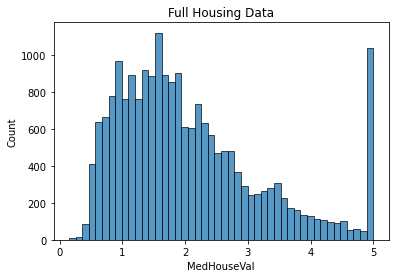

In [9]:
# Present histogram of MedHouseVal for all values
sns.histplot(data=df_housing, x='MedHouseVal')
plt.title("Full Housing Data")


**Visually we can see there must have been a cutoff at the 5 mark for the original data. It makes sense to get rid of this.**

Text(0.5, 1.0, 'Housing with MedHouseVal <= 5')

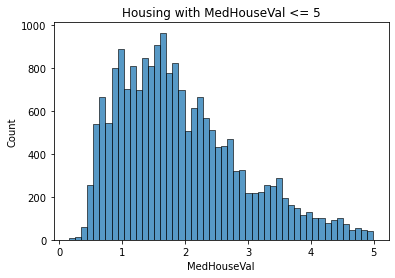

In [10]:
# remove the houses where `MedHouseVal` is greater or equal to 5
df_housing.drop(df_housing[df_housing['MedHouseVal'] >= 5].index, inplace=True)

# Present histogram of MedHouseVal after removing houses >= 5
sns.histplot(data=df_housing, x='MedHouseVal')
plt.title("Housing with MedHouseVal <= 5")

**Now the data looks to be normally distributed with a left skew.**

In [11]:
# remove `Latitude` and `Longitude`
df_housing.drop(columns=['Latitude', 'Longitude'], inplace=True)

# review shape and head of dataframe
display(df_housing.shape)
df_housing.head()

(19648, 7)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,3.422


**We might be able to create a surrogate for the latitude and longitude with area in california, then one-hot encode, but that would take too much work. It makes sense just to get rid of it.**

In [12]:
# create column names 
col_names_features = list((df_housing.columns).drop('MedHouseVal'))
col_names_features

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']

**Will be using the column names for dataframes down the pipeline. Handy to have them in one variable. I dropped the target columns to isolate all of the feature columns instead of listing them all out. Thought this was a tricky way of getting the feature column names.**

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# split the data into features and target
X = df_housing.loc[:, ~df_housing.columns.isin(['MedHouseVal'])]
y = df_housing['MedHouseVal']

# split the features and target into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# normalize the training and test features based on the training data 
# initialize scaler instance
scaler = StandardScaler()

# fit scaler to training features
scaler.fit(X_train)

# create normalized training and testing features
X_train_norm = pd.DataFrame(scaler.transform(X_train), columns=col_names_features) 
X_test_norm = pd.DataFrame(scaler.transform(X_test), columns=col_names_features)

# review
X_train_norm[:5]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup
0,-0.672267,1.080017,-0.243985,-0.281555,-0.103423,0.037194
1,2.558825,0.442922,0.505025,-0.050796,-0.392321,0.017048
2,-0.432294,-0.034899,0.119560,0.146132,0.788913,0.050233
3,0.978370,0.442922,-0.211340,0.137866,-0.901739,-0.099288
4,-0.399007,-0.751631,-0.456789,-0.223674,-0.264112,-0.042391


**Found another tricky way to select all othe columns using the .loc function of the dataframe. The values appear to be normalized and ready for training. We did not normalize the target values as they don't necessarily need to be normalized to make a prediction.**

2. Train and Predict
- Train a linear regression algorithm, using `LinearRegression` from `sklearn.linear_model`, to predict `MedHouseVal` on the prepared data.
- predict benchmark values for both training and test data sets.
<br/><span style="color:red" float:right>[1 point]</span>

In [14]:
# Add code here
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train_norm, y_train)

y_hat_train_benchmark = linreg.predict(X_train_norm)
y_hat_test_benchmark = linreg.predict(X_test_norm)

3. Evaluate the model
<br/>Calculate and report the performance (RMSE) on both training and test data. These numbers will serve as our benchmark performance. As a sanity check, create a scatter plot of the bench mark predictions against the actual values for the each of the two (train, test) data sets.
<br/><span style="color:red" float:right>[2 point]</span>

In [15]:
# Calculate and report RMSE
train_rmse = MSE(y_train, y_hat_train_benchmark, squared=False)
test_rmse = MSE(y_test, y_hat_test_benchmark, squared=False)

print(f"The RMSE for the training data is: {train_rmse:.2f}")
print(f"The RMSE for the testing data is: {test_rmse:.2f}")

The RMSE for the training data is: 0.69
The RMSE for the testing data is: 0.68


Text(0, 0.5, 'Predicted')

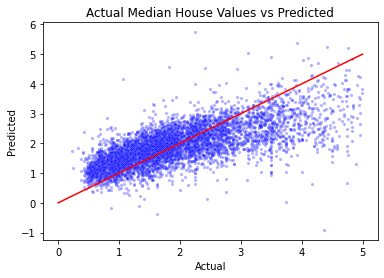

In [16]:
# scatter plot of the bench mark predictions against the actual values
plottingData = pd.DataFrame({'y_test':y_test, 'y_hat_test':y_hat_test_benchmark})
plottingData = plottingData.reset_index()
plottingData.drop(columns='index', inplace=True)

# create a 1:1 x/y variables
x = [0,1,2,3,4,5]
y = [0,1,2,3,4,5]

# create scatter plot
fig, ax = plt.subplots()
sns.scatterplot(data=plottingData, x='y_test', y='y_hat_test', alpha=0.3, s=10, c=['blue'])
plt.plot(x,y, color='red')
plt.title('Actual Median House Values vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')

We now train a regularized version of `LinearRegression` called `Lasso` (you can load it from the sklearn.linear_model.Lasso). `Lasso` has an argument called `alpha`, which is the **shrinkage parameter** we referred to earlier.

4. Let `alpha = 0.000001` and train a `Lasso` model. Show that the resulting model is practically identical to the one we trained with `LinearRegression`. There are different ways to show this, so you will need to think of a way. <span style="color:red" float:right>[2 point]</span>

In [17]:
from sklearn.linear_model import Lasso
from sklearn.metrics import classification_report

# Create instance
lasso = Lasso(alpha = 0.000001)

# Fit model to training data
lasso.fit(X_train_norm, y_train)

# create lasso predictions
y_hat_train_lasso = lasso.predict(X_train_norm)
y_hat_test_lasso = lasso.predict(X_test_norm)

# create lasso dataframe
plottingLasso = pd.DataFrame({'y_test':y_test, 'y_hat_test_lasso':y_hat_test_lasso})
plottingLasso = plottingData.reset_index()
plottingLasso.drop(columns='index', inplace=True)

In [18]:
# show two dataframes
print("Regression Dataframe")
display(plottingData.round(2))
print("Lasso Dataframe")
display(plottingLasso.round(2))

Regression Dataframe


,y_test,y_hat_test
0,3.67,2.63
1,2.15,2.36
2,1.34,1.70
3,1.56,1.70
4,0.74,1.24
...,...,...
5890,3.33,2.72
5891,2.62,1.71
5892,1.97,2.52
5893,3.72,3.11


Lasso Dataframe


,y_test,y_hat_test
0,3.67,2.63
1,2.15,2.36
2,1.34,1.70
3,1.56,1.70
4,0.74,1.24
...,...,...
5890,3.33,2.72
5891,2.62,1.71
5892,1.97,2.52
5893,3.72,3.11


In [19]:
# create another rmse instance
rmse_train_lasso = MSE(np.array(y_train), y_hat_train_lasso, squared=False)
rmse_test_lasso = MSE(np.array(y_test), y_hat_test_lasso, squared=False)

In [20]:
# Compare the models
col_names = ['RMSE_Reg_train', 'RMSE_Reg_test', 'RMSE_Lasso_train', 'RMSE_Lasso_test']
rmse_values = [train_rmse.round(2), test_rmse.round(2), rmse_train_lasso.round(2), rmse_test_lasso.round(2)]

rmse_zip = list(zip(col_names, rmse_values))
rmse_df = pd.DataFrame(rmse_zip, columns=['TestType', 'RMSE'])
rmse_df = rmse_df.set_index('TestType')
rmse_df

,RMSE
TestType,
RMSE_Reg_train,0.69
RMSE_Reg_test,0.68
RMSE_Lasso_train,0.69
RMSE_Lasso_test,0.68


#### Comment on the comparison
Add Comment here

5. Get regression coefficients and performance metrics for varying alpha.  The performance metrics are  RMSE for training and test data.  
<span style="color:red" float:right>[5 point]</span>

In [21]:
# The alpha column contains the values we want to iterate over
# The other columns are for storing the coefficients of the lasso regressions
Coefficients = pd.DataFrame(data=np.array((np.arange(0.01, 1, .01))), columns=['alpha'])
Coefficients[list(X.columns) + ['RMSE_train', 'RMSE_test']] = 0

In [22]:
# Review Coefficients df
Coefficients

,alpha,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,RMSE_train,RMSE_test
0,0.01,0,0,0,0,0,0,0,0
1,0.02,0,0,0,0,0,0,0,0
2,0.03,0,0,0,0,0,0,0,0
3,0.04,0,0,0,0,0,0,0,0
4,0.05,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
94,0.95,0,0,0,0,0,0,0,0
95,0.96,0,0,0,0,0,0,0,0
96,0.97,0,0,0,0,0,0,0,0
97,0.98,0,0,0,0,0,0,0,0


To make it easier, we have laid out a suggestion for the code. You can use our layout or you can design your own code.
For each iteration in the suggested design:    
- Train a new `Lasso` model, letting `alpha` change each time to one of the values given by `alpha_vals` below.  
- For each value of `alpha` in `Coefficients`, retrieve the coefficients from the `coef_` attribute of the trained model. 
- Store the coefficients in `Coefficients`
- Predict the training labels, e.g. `y_hat_train`
- Determine the rmse of the training data, e.g. `rmse_train`
- Store the rmse of the training data in `Coefficients`
- Predict the test labels, e.g. `y_hat_test`
- Determine the rmse of the test data, e.g. `rmse_test`
- Store the rmse of the test data in `Coefficients`

In [23]:
# loop over the alpha values and do this:
rmse_list = []
for key, row in Coefficients.iterrows():
    # create alpha variable
    a = row['alpha']
    
    # instantiate a Lasso regression with alpha
    lasso = Lasso(alpha=a)

    # fit the lasso regression
    lasso.fit(X_train_norm, y_train)
    
    # add the coefficients to the DataFrame row
    coefficients = lasso.coef_
    row.iloc[1:7] = coefficients
    
    # predict training labels (y_hat for training)
    y_hat_train = lasso.predict(X_train_norm)
    
    # determine training error metric (RMSE)
    rmse_train = MSE(y_train, y_hat_train, squared=False)
   
    # add the training error metric (RMSE) to the DataFrame row
    row.loc['RMSE_train'] = rmse_train
    # predict test labels (y_hat for test)
    y_hat_test = lasso.predict(X_test_norm)
    
    # determine test error metric (RMSE)
    rmse_test = MSE(y_test, y_hat_test)
    
    # add the test error metric (RMSE) to the DataFrame row
    row['RMSE_test'] = rmse_test
    
    rmse_list.append(row)

In [24]:
# create dataframe from list of rmse rows
alpha_df = pd.DataFrame(rmse_list)
alpha_df

,alpha,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,RMSE_train,RMSE_test
0,0.01,0.780386,0.172861,-0.353699,0.298734,0.019450,-0.034546,0.691015,0.476934
1,0.02,0.706069,0.160840,-0.183621,0.136246,0.008448,-0.021288,0.700584,0.493011
2,0.03,0.641089,0.149181,-0.038842,0.000000,0.000000,-0.008487,0.713614,0.513236
3,0.04,0.624502,0.138013,-0.025648,0.000000,0.000000,-0.000000,0.716020,0.517253
4,0.05,0.608261,0.127049,-0.012572,-0.000000,0.000000,-0.000000,0.718547,0.521377
...,...,...,...,...,...,...,...,...,...
94,0.95,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.970621,0.945117
95,0.96,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.970621,0.945117
96,0.97,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.970621,0.945117
97,0.98,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.970621,0.945117


6. Lasso changes with alpha
<br/>
(a) Using a visual, show how the performance on the training and test data changed as we gradually increased the shrinkage parameter `alpha`. At which point is there a substantial decrease in performance (increase in RMSE) on the test data?  You might want to use a log scale (`plt.xscale('log')`) for `alpha`.
<br/>
(b) Using a visual, show how the model's coefficients changed as we gradually increased the shrinkage parameter `alpha`. HINT: They should appear to be shrinking toward zero as you increase `alpha`. 
<br/><span style="color:red" float:right>[4 point]</span>

Text(0.5, 1.0, 'Lasso RMSE with increasing alpha')

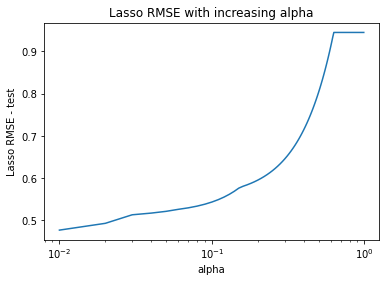

In [25]:
# Add code here
sns.lineplot(data=alpha_df, x='alpha', y='RMSE_test')
plt.xscale('log')
plt.ylabel('Lasso RMSE - test')
plt.title('Lasso RMSE with increasing alpha')

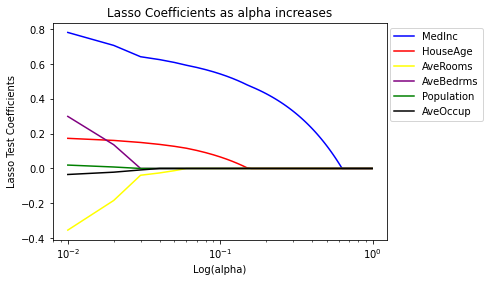

In [26]:
# Add code here
ax, fig = plt.subplots()

sns.lineplot(data=alpha_df, x='alpha', y='MedInc', color='blue', legend='full')
sns.lineplot(data=alpha_df, x='alpha', y='HouseAge', color='red')
sns.lineplot(data=alpha_df, x='alpha', y='AveRooms', color='yellow')
sns.lineplot(data=alpha_df, x='alpha', y='AveBedrms', color='purple')
sns.lineplot(data=alpha_df, x='alpha', y='Population', color='green')
sns.lineplot(data=alpha_df, x='alpha', y='AveOccup', color='black')
plt.xscale('log')
plt.xlabel('Log(alpha)')
plt.title('Lasso Coefficients as alpha increases')
plt.ylabel('Lasso Test Coefficients')
plt.legend(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup'], loc="upper right", bbox_to_anchor=(1.3, 1))

7. Compare `Ridge` and `Lasso` baseline models.  Show that `Ridge` and `Lasso` return the same trained model when `alpha = 0.00001` (i.e. close to zero). <br/><span style="color:red" float:right>[1 point]</span>

In [27]:
from sklearn.linear_model import Ridge 

# fit the ridge regression and refit Lasso with same alpha

lasso = Lasso(alpha = 0.00001)
ridge = Ridge(alpha = 0.00001)

lasso.fit(X_train_norm, y_train)
ridge.fit(X_train_norm, y_train)

# compare the coefficients
coef_comp_list = [lasso.coef_, ridge.coef_]

coeff_ridge_lasso_df = pd.DataFrame(coef_comp_list, columns=col_names_features, index=['Lasso', 'Ridge'])

display(coeff_ridge_lasso_df)

# compare predicted test labels (y_hat for test) 
y_hat_test_ridge = ridge.predict(X_test_norm)

rmse_ridge = MSE(y_test, y_hat_test_ridge)
print("The RMSE for the Ridge regression if: {}".format(rmse_ridge.round(2)))


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup
Lasso,0.854839,0.184844,-0.524130,0.461520,0.030422,-0.047796
Ridge,0.854914,0.184856,-0.524302,0.461684,0.030433,-0.047809


The RMSE for the Ridge regression if: 0.47


8. Get regression coefficients and performance metrics for varying `alpha` on a ridge regression.  The performance metrics are  RMSE for training and test data.  In other words, repeat the above using `Ridge` instead of `Lasso`.   For `ridge`, we will use the following range for `alpha`: `np.power(2., np.arange(1., 25., 1.))`

> Note: Ridge has a  different behaviour than Lasso. Coefficients will very gradually approach zero and not have a steep drop off. You probably will not notice any zero coefficients.

<br/><span style="color:red" float:right>[1 point]</span>

In [28]:
# Add code here
alpha_values = np.power(2., np.arange(1., 25., 1.))

# The alpha column contains the values we want to iterate over
# The other columns are for storing the coefficients of the ridge regressions
Coefficients = pd.DataFrame(data=alpha_values, columns=['alpha'])
Coefficients[list(X.columns) + ['RMSE_train', 'RMSE_test']] = float('nan')

In [29]:
# review coefficients and alpha values
Coefficients.head()

,alpha,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,RMSE_train,RMSE_test
0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# loop over the alpha values and do this:
ridge_coeff_list = []
for key, row in Coefficients.iterrows():
    # instantiate a ridge regression with alpha
    ridge = Ridge(alpha=row['alpha'])
    # fit the ridge regression
    ridge.fit(X_train_norm, y_train)
    # add the coefficients to the DataFrame row
    row.iloc[1:7] = ridge.coef_
    # predict training labels (y_hat for training)
    y_hat_train_ridge = ridge.predict(X_train_norm)
    # determine training error metric (RMSE)
    train_rmse = MSE(y_train, y_hat_train_ridge)
    # add the training error metric (RMSE) to the DataFrame row
    row['RMSE_train'] = train_rmse
    # predict test labels (y_hat for test)
    y_hat_test_ridge = ridge.predict(X_test_norm)
    # determine test error metric (RMSE)
    test_rmse = MSE(y_test, y_hat_test_ridge)
    # add the test error metric (RMSE) to the DataFrame row
    row['RMSE_test'] = test_rmse
    # append row to new list
    ridge_coeff_list.append(row)

In [31]:
# create dataframe with new values
ridge_coeff_df = pd.DataFrame(ridge_coeff_list)
ridge_coeff_df.head()

,alpha,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,RMSE_train,RMSE_test
0,2.0,0.854279,0.184844,-0.522907,0.460379,0.030455,-0.047784,0.473048,0.468929
1,4.0,0.853646,0.184831,-0.521518,0.459079,0.030477,-0.047759,0.473049,0.468959
2,8.0,0.852387,0.184806,-0.518758,0.456498,0.030520,-0.047710,0.473052,0.469020
3,16.0,0.849897,0.184754,-0.513313,0.451406,0.030603,-0.047612,0.473065,0.469145
4,32.0,0.845030,0.184642,-0.502709,0.441490,0.030763,-0.047418,0.473113,0.469412


9. Ridge changes with alpha
<br/>
(a) Using a visual, show how the performance on the training and test data changed as we gradually increased `alpha` for `Ridge`. In other words, repeat the above using `Ridge` instead of `Lasso`.  
<br/>
(b) Using a visual, show how the model's coefficients for ridge changed as we gradually increased the shrinkage parameter `alpha`.  
<br/><span style="color:red" float:right>[2 point]</span>

Text(0.5, 1.0, 'Ridge RMSE with increasing alpha')

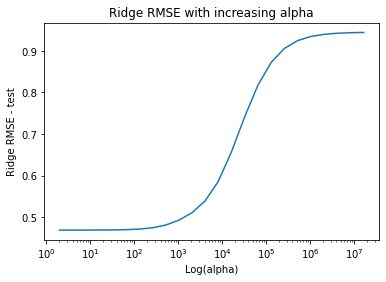

In [32]:
# RMSE vs. alpha
sns.lineplot(data=ridge_coeff_df, x='alpha', y='RMSE_test')
plt.xscale('log')
plt.ylabel('Ridge RMSE - test')
plt.xlabel('Log(alpha)')
plt.title('Ridge RMSE with increasing alpha')

**At about **

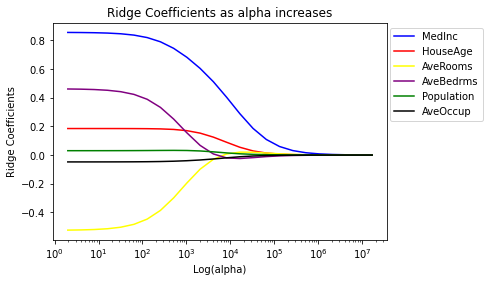

In [33]:
# Coefficients vs alpha
ax, fig = plt.subplots()

sns.lineplot(data=ridge_coeff_df, x='alpha', y='MedInc', color='blue', legend='full')
sns.lineplot(data=ridge_coeff_df, x='alpha', y='HouseAge', color='red')
sns.lineplot(data=ridge_coeff_df, x='alpha', y='AveRooms', color='yellow')
sns.lineplot(data=ridge_coeff_df, x='alpha', y='AveBedrms', color='purple')
sns.lineplot(data=ridge_coeff_df, x='alpha', y='Population', color='green')
sns.lineplot(data=ridge_coeff_df, x='alpha', y='AveOccup', color='black')
plt.xscale('log')
plt.title('Ridge Coefficients as alpha increases')
plt.ylabel('Ridge Coefficients')
plt.xlabel('Log(alpha)')
plt.legend(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup'], loc="upper right", bbox_to_anchor=(1.3, 1))



**Using the ridge regression model it looks like the coefficient shrinkage happens more smoothly than the Lasso regression.**

10. Based on the results, briefly describe the effect of changing `alpha` on the coefficients of both `Ridge` and `Lasso`. What value of `alpha` would you choose for each case? You do not need to give a precise answer, but choose a number. <br/><span style="color:red" float:right>[2 point]</span>

#### Comments on regularization using ridge and lasso
**We can see a more smooth and separated coefficient shrinkage for the Ridge Regression. It is still clear that as the alpha value increases at a certain point the coefficients shrink towards zero.**


# End of assignment